In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap

# import custom functions from src folder
module_path = str(Path.cwd() / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from robot import Robot
from util import *

### The robot
Inside the box there is a two-joint robot-arm which draws points on a surface. The screen shows the position of the point the robot arm reached. The position the robot reaches is decided by the parameters $r_1$, $r_2$, $\theta_1$ and $\theta_2$, indicating the length of the first and second rod and the angle of the joints.


$(\theta_1, \theta_2, r_1, r_2) \rightarrow (x_1, x_2) = (r_1 \cos(\theta_1) + r_2 \cos(\theta_1 + \theta_2), r_1 \sin(\theta_1) + r_2 \sin(\theta_1 + \theta_2))$

<p align="center">
  <img src="../fig/toy_experiment_robot_arm.png" height="350">
</p>

The robot maker has made the machine non-deterministic by letting three of the four parameters be drawn from fixed distributions. Internally, the algorithm first decides the color (or a color button is pressed), then $\theta_1, \theta_2$ and $r_1$ are randomly sampled from their distributions. The first joint can rotate 360 degrees, while the second joint can rotate only 180 degrees as indicated in the figure. $\theta_1$ and $\theta_2$ are chosen completely randomly within these constraints. The length of the first arm, $r_1$, is set by an extending mechanism according to the chosen color $c$. The extending mechanism is not very precise and only approximately hits the programmed length $R_{c}$. The actually reached length is modelled by a gamma function with mean at $\mu_{r1, c} = k_{c} s = R_{c}$. When the 'simulation' button is pressed, the colors are first drawn from a discrete distribution.


Distributed features:

$
\begin{aligned}
& c \in\left\{\text { "red" }, \text { "blue" }\right\} \\
& \vec{\theta} = \left(\theta_1, \theta_2\right) \\
& \theta_1 \in[0,2 \pi) \subseteq \mathbb{R}^1 \\
& \theta_2 \in[0, \pi) \subseteq \mathbb{R}^1 \\
& \vec{x}=\left(x_1, x_2\right) \in X \subseteq \mathbb{R}^2 \\
& r_1 \in\left(r_{1, min}, \infty\right) \subseteq \mathbb{R}^1
\end{aligned}
$

Constant features:

$
\begin{aligned}
& r_2 \\
& r_{1, min} > r_2
\end{aligned}
$

Known distributions:

$
\begin{aligned}
& P_c(c)= \begin{cases}P_{\text{red}}, & c=\text { red } \\
1-P_{\text{red}}, & c=\text { blue }\end{cases} \\
& p_{\theta_1}\left(\theta_1\right)=1 / 2 \pi \\
& p_{\theta_2}\left(\theta_2\right)=1 / \pi
\end{aligned}
$

$
\begin{aligned}
p_{r_1}\left(r_1 \mid c\right)=\frac{\left(r_1-r_{1, min}\right)^{k_c-1} e^{-(r_1-r_{1, min}) / s}}{s^{k_c} \Gamma\left(k_c\right)}
\end{aligned}
$

$
\begin{aligned}
& k_c= \begin{cases}k_r, & c=\text { red } \\
k_b < k_r, & c=\text { blue }\end{cases} \\
\end{aligned}
$

$s=$ constant

Functional dependence:

$
\begin{aligned}
& \vec{x}=\vec{g}\left(\theta_1, \theta_2, r_1\right)=\left(g_1(\theta_1, \theta_2, r_1), g_2(\theta_1, \theta_2, r_1)\right)=\left(x_1, x_2\right) \\
& g_1=r_1 \cos \theta_1+r_2 \cos \left(\theta_1+\theta_2\right) \\
& g_2=r_1 \sin \theta_1+r_2 \sin \left(\theta_1+\theta_2\right)
\end{aligned}
$



### But wait, you said this was a real problem and now it's all math?
This is as good as it is ever going to get with calculus. Even if we could set up the problem as discrete positions of the robot's gears and the acutator's possible positions, for any realistic example, the number of possible positions for the arm would be too large to process to calculate the probabilities.

### I like the math, but this is not physics!
The problem can easily be translated into a simplified particle physics problem. Imagine a particle which is emitted from $(0,0)$ at an angle $\theta_1$ and travels through space with constant speed $c$ for a period of time $\tau_1$ before it decays into an undetectable particle and a detectable particle which travels at angle $\theta_2$ for a time $\tau_2$ before it is detected at $(x_1, x_2)$. If the parameters in this problem $\theta_1, \theta_2, \tau_1$ and $\tau_2$ are distributed differently for different particle types such that there is an overlap in the end distribution of $(x_1, x_2)$ as more data is sampled, the math is quite similar to a very simplified version of a classification problem in particle physics.

In [3]:
def robot_arm(theta1, theta2, r1, r2):
    ya = r1*np.cos(theta1) + r2*np.cos(theta1 + theta2)
    yb = r1*np.sin(theta1) + r2*np.sin(theta1 + theta2)
    return ya, yb

In [4]:
color = ["#e41a1c", "#313695"]

In [5]:
myRobot = Robot(seed=24)
params = myRobot.get_parameters()
R_2 = params["R2"]
scale = params["scale"]
k_red = params["k_red"]
k_blue = params["k_blue"]

Text(0, 0.5, 'x2')

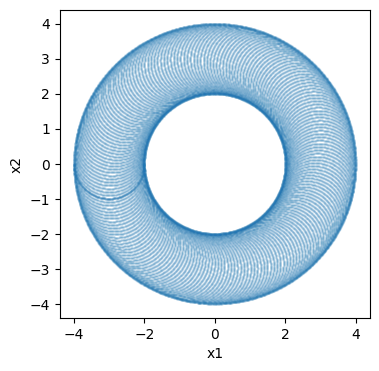

In [6]:
# Look at the mapping function for constant R
nx = 200
#angles
a1 = np.linspace(-np.pi, np.pi, nx)
a2 = np.linspace(0, np.pi, nx)
aa1, aa2 = np.meshgrid(a1, a2)

r1 = 3
r2 = 1

xx1, xx2 = robot_arm(aa1, aa2, r1, r2)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4))

ax.scatter(xx1, xx2, s=1, alpha=0.1)
ax.set_xlabel("x1")
ax.set_ylabel("x2")

Text(0, 0.5, 'x1')

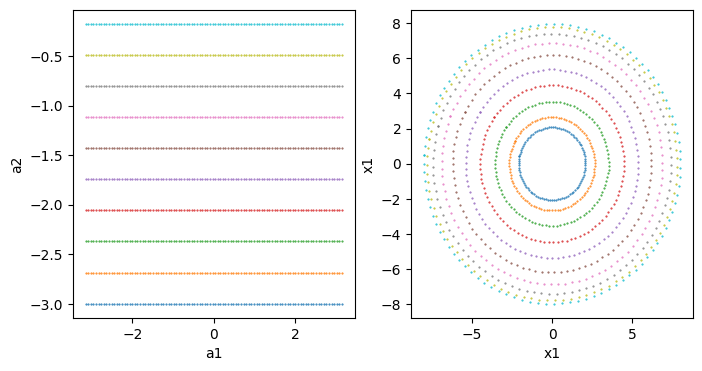

In [7]:
# Look at the mapping function for constant theta2
na = 100

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
lines = 10
a1 = np.linspace(-np.pi, np.pi, na)
for i in range(lines):
    da2 = np.pi/lines
    a2 = 0*a1 -3 + i*da2
    x1, x2 = robot_arm(a1, a2, 5, R_2)
    ax[0].plot(a1, a2, marker='.', markersize=1, linestyle='none')
    ax[1].plot(x1, x2, marker='.', markersize=1, linestyle='none')

ax[0].set_xlabel("a1")
ax[0].set_ylabel("a2")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x1")

Text(0, 0.5, 'x1')

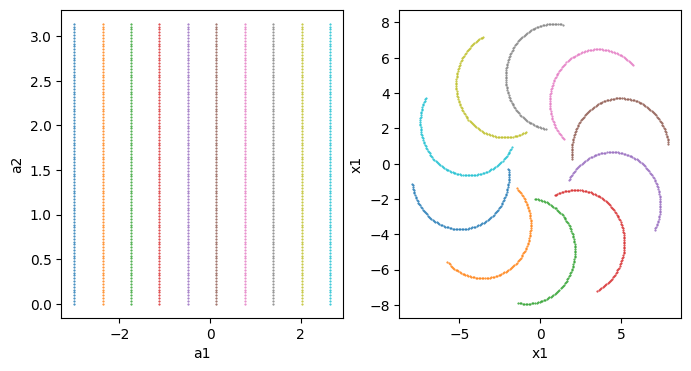

In [8]:
# Look at the mapping function for constant theta1
na = 100

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
lines = 10
a2 = np.linspace(0, np.pi, na)
for i in range(lines):
    da1 = 2*np.pi/lines
    a1 = 0*a2 -3 + i*da1
    x1, x2 = robot_arm(a1, a2, 5, R_2)
    ax[0].plot(a1, a2, marker='.', markersize=1, linestyle='none')
    ax[1].plot(x1, x2, marker='.', markersize=1, linestyle='none')

ax[0].set_xlabel("a1")
ax[0].set_ylabel("a2")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x1")

In [9]:
# Custom plot function
def plot_data(df):

    fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 8), layout="constrained")

    df_red = df[df["color"] == "red"]
    sn.scatterplot(df_red, x="x1", y = "x2", c="red", alpha=0.1, ax=ax[0][0])
    sn.histplot(df_red[["x1", "x2"]], palette=["#ffae9d", "#a82b11"], alpha=0.5, ax=ax[0][1], element="step")
    
    df_blue = df[df["color"] == "blue"]
    sn.scatterplot(df_blue, x="x1", y = "x2", c="blue", alpha=0.1, ax=ax[1][0])
    sn.histplot(df_blue[["x1", "x2"]], palette=["#f7f7f7", "#313695"], alpha=0.5, ax=ax[1][1], element="step")
    
    ax[0][0].set_xlim(min(df["x1"]), max(df["x1"]))
    ax[1][0].set_xlim(min(df["x1"]), max(df["x1"]))
    ax[0][0].set_ylim(min(df["x2"]), max(df["x2"]))
    ax[1][0].set_ylim(min(df["x2"]), max(df["x2"]))
    
    # Plot r1
    sn.histplot(df_red, x="r1", color="red", ax=ax[0][2])
    sn.histplot(df_blue, x="r1", color="blue", ax=ax[1][2])
    sn.lineplot(x=[2*R_2 + k_red*scale]*2, y=[0, 1700], estimator=None, lw=2, alpha=1, c="black", ax=ax[0][2], label="Expected mean")
    sn.lineplot(x=[2*R_2 + k_blue*scale]*2, y=[0, 1700], estimator=None, lw=2, alpha=1, c="black", ax=ax[1][2], label="Expected mean")
    ax[0][2].set_xlim(R_2, max(df["r1"]))
    ax[1][2].set_xlim(R_2, max(df["r1"]))

    return fig, ax



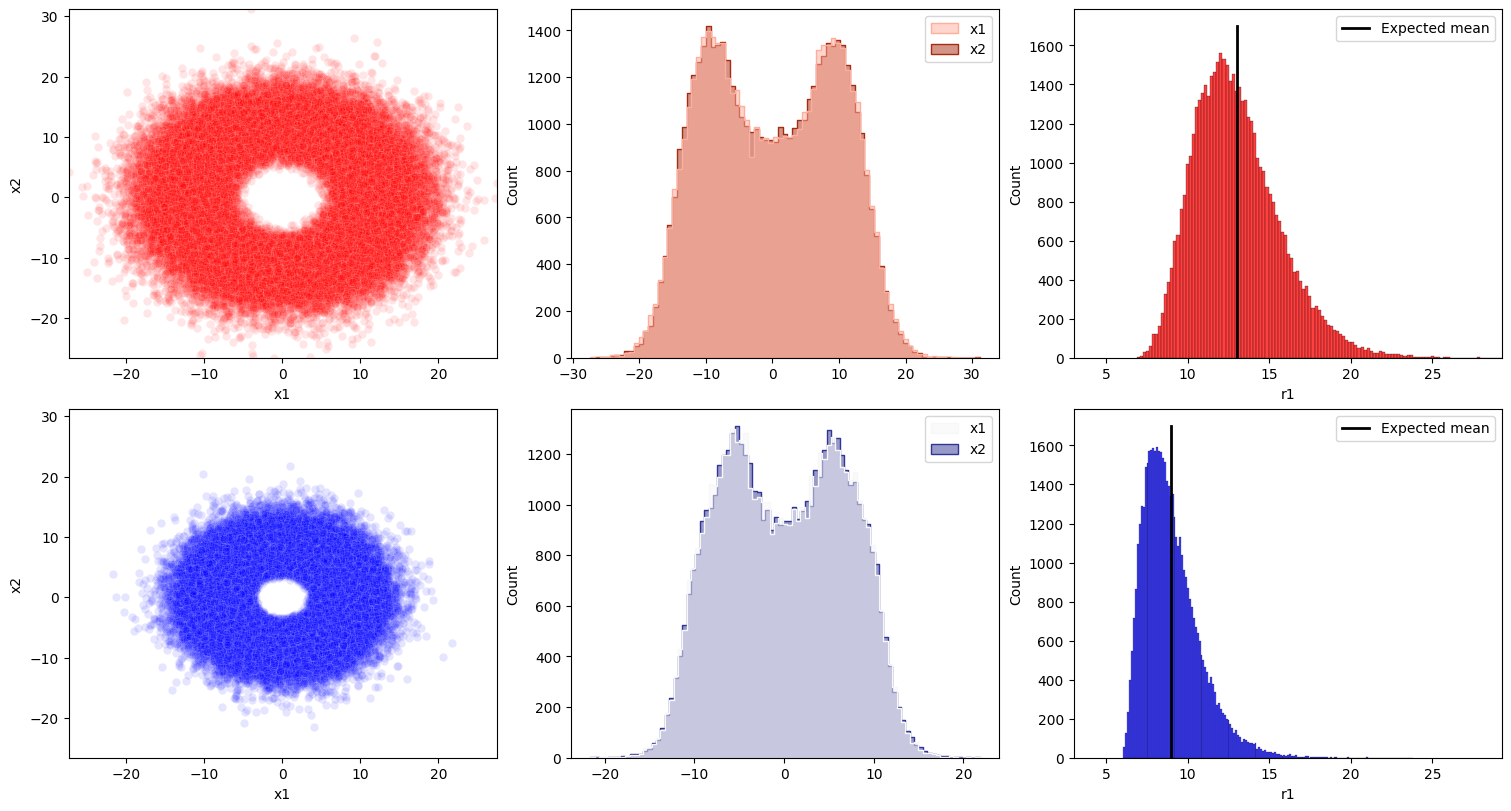

In [10]:
df_many = myRobot.simulate(100000, black_box=False)
fig, ax = plot_data(df_many)

<Axes: xlabel='x1', ylabel='x2'>

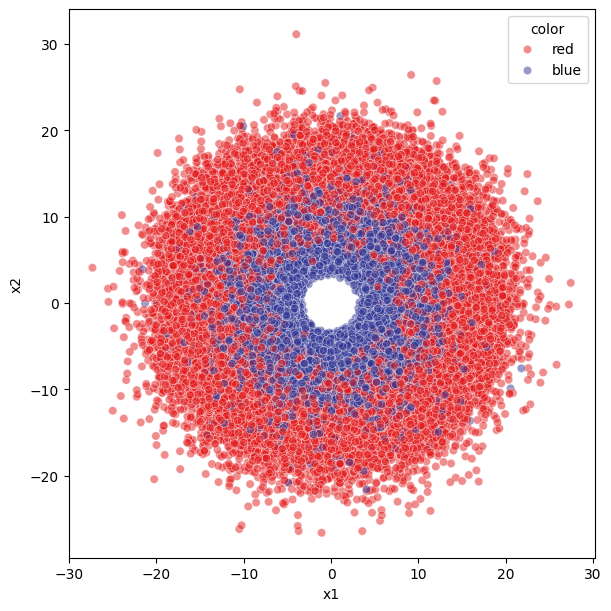

In [11]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 6), layout="constrained")
sn.scatterplot(df_many, x="x1", y="x2", hue="color", palette=color, alpha=0.5, ax=ax)

<Axes: xlabel='a1', ylabel='Count'>

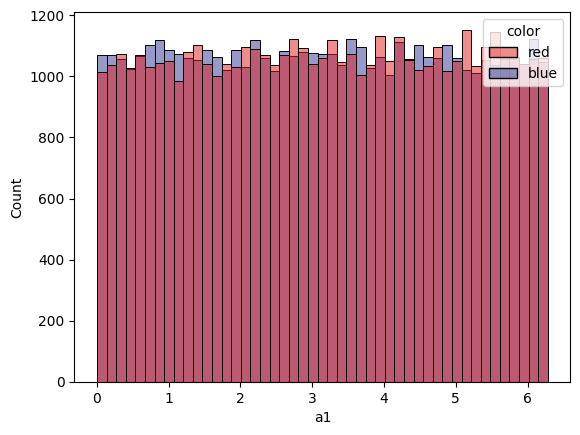

In [12]:
sn.histplot(df_many, x="a1", hue="color", palette=color)

<Axes: xlabel='r1', ylabel='Count'>

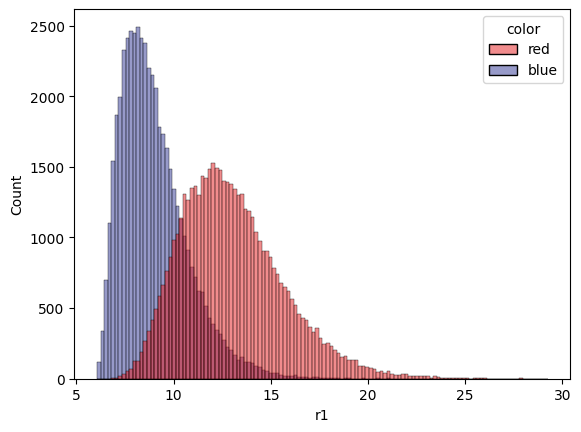

In [13]:
sn.histplot(df_many, x="r1", hue="color", palette=color)

<Axes: xlabel='x1', ylabel='Count'>

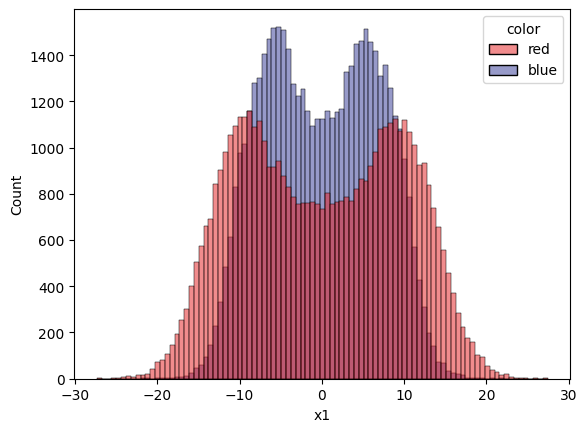

In [14]:
sn.histplot(df_many, x="x1", hue="color", palette=color)

<Axes: xlabel='x2', ylabel='Count'>

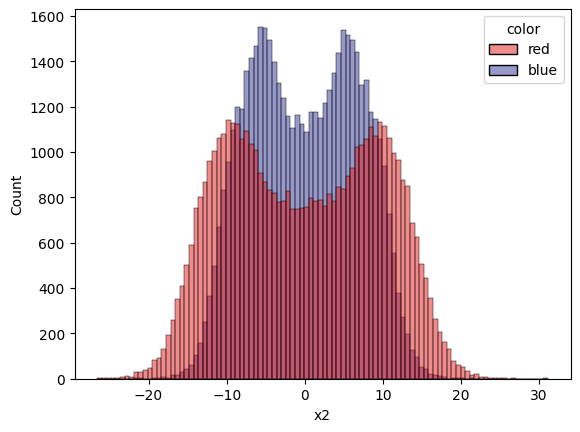

In [15]:
sn.histplot(df_many, x="x2", hue="color", palette=color)